In [95]:
import pyodbc
import pandas as pd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

try:
    conn_str = "Driver={SQL Server};Server=Z690-ELDER;Database=SentimentAnalysis;Trusted_Connection=yes;"
    conn_url = URL.create("mssql+pyodbc", query={"odbc_connect": conn_str})
    engine = create_engine(conn_url)
        
    df = pd.read_sql("SELECT * FROM dbo.Twitter", engine)
            
except pyodbc.Error as e:
    print("Error while connecting to db", e)

#display UserKey and Tweet
df[['UserKey', 'Tweet']].style

,UserKey,Tweet
0,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,"Fitch have affirmed Malta's A+ rating, lauding the first Budget of this administration as expansionary with many social measures that will lead to inflation being among the lowest in the euro zone. They confirm this is sustainable as we are boosting Malta's economic potential.-RA"
1,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,"After the IMF forecast that next year Malta's growth will be six times the EU average, now the European Commission is predicting that our economic growth will be nine times the EU average. @MaltaGov policies are making a real difference. - RA"
2,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,In a meeting with @OSCE_RfoM I underlined several reforms undertaken to further enhance the protection of journalists. The media is a vital pillar in our democracy. @MaltaGov remains strongly committed to deliver even more and will continue to support the work of @OSCE. - RA https://t.co/FnsITrNIKW
3,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,"RT @PES_PSE: We, European socialists, want to lead a fair transition to greener societies and economies. That's why we are as united as eve…"
4,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,Saddened to learn about the passing of Notary Tony Abela. Heartfelt condolences to all his family. May he rest in peace. - RA
5,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,During my national statement at #COP27 I reiterated my call for global action to combat #climatechange. #Malta will strengthen its resolve & bolster its support to Small Island Developing States. Our action or inaction will define our relationship with our planet. - RA https://t.co/H09CZozPAB
6,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,Met with @PScotlandCSG in the margins of #COP27. We discussed impacts of #climatechange on small states. I thanked her for entrusting #Malta to serve on the Commonwealth Ministerial Action Group where we will keep on advocating in favour of sustainable development goals. - RA https://t.co/0DWi7Sv5kR
7,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,"Arrived in Sharm El-Sheikh for #COP27. #Malta is committed to the Paris principles as well as our resolve to keep the 1.5-degree target alive. But now, collectively & globally, we must move beyond to take decisive action. – RA"
8,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,I pay tribute to former PM and PL Leader Karmenu Mifsud Bonnici. A politician who stood up for the working class and social justice. Thank you for your relentless service to the nation. Sincere condolences to his family. - RA https://t.co/01B3L5BBQy
9,DFD035A3-9B62-ED11-B67D-D85ED3AE4DFE,"By continuing to protect families and firms from the effects of extreme economic shocks, while at the same time increasing public investment, Budget 2023 provides the certainty and stability required to build a new prosperity for our country. - RA"


In [96]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords

train_original = pd.read_csv('./TrainingData/trainingdata2.csv')
train_original.columns = ['target','id','date','flag','user','text']

train=train_original[['id','text']]

test = df[['UserKey', 'Tweet']]
test.columns = ['id', 'text']

combine = train.append(test,ignore_index=True,sort=True)

def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

#remove newlines
combine['Tidy_Tweets'] = combine['text'].str.replace("\n"," ")
#remove links
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace('http\S+|www.\S+', '', case=False)
combine['wtf'] = combine['Tidy_Tweets'].str.replace('http\S+|www.\S+', '', case=False)
# remove twitter handles (@user)
combine['Tidy_Tweets'] = np.vectorize(remove_pattern)(combine['text'], "@[\w]*")
#remove special characters, numbers, punctuations
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#]", " ")
#remove short words (length < 3)
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
#remove duplicate tweets - bot prevention
combine = combine.drop_duplicates(subset=['Tidy_Tweets'], keep=False)
#remove quotes
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("quot", "")

combine.head()

C:\Users\andre\AppData\Local\Temp\ipykernel_26468\144261929.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combine = train.append(test,ignore_index=True,sort=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_26468\144261929.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace('http\S+|www.\S+', '', case=False)
C:\Users\andre\AppData\Local\Temp\ipykernel_26468\144261929.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  combine['wtf'] = combine['Tidy_Tweets'].str.replace('http\S+|www.\S+', '', case=False)
C:\Users\andre\AppData\Local\Temp\ipykernel_26468\144261929.py:40: FutureWarning: The default value of regex will change from True to False in a future version.
  combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#

,id,text,Tidy_Tweets,wtf
0,1467810672,is upset that he can't update his Facebook by ...,upset that update Facebook texting might resul...,is upset that he can't update his Facebook by ...
1,1467810917,@Kenichan I dived many times for the ball. Man...,dived many times ball Managed save rest bounds,@Kenichan I dived many times for the ball. Man...
2,1467811184,my whole body feels itchy and like its on fire,whole body feels itchy like fire,my whole body feels itchy and like its on fire
3,1467811193,"@nationwideclass no, it's not behaving at all....",behaving here because over there,"@nationwideclass no, it's not behaving at all...."
4,1467811372,@Kwesidei not the whole crew,whole crew,@Kwesidei not the whole crew


In [97]:
'''from nltk import PorterStemmer

#tokenization
tokenized_tweet = combine['Tidy_Tweets'].apply(lambda x: x.split())

ps = PorterStemmer()

#removing suffixes
tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combine['Tidy_Tweets'] = tokenized_tweet'''

"from nltk import PorterStemmer\n\n#tokenization\ntokenized_tweet = combine['Tidy_Tweets'].apply(lambda x: x.split())\n\nps = PorterStemmer()\n\n#removing suffixes\ntokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])\n\nfor i in range(len(tokenized_tweet)):\n    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])\n\ncombine['Tidy_Tweets'] = tokenized_tweet"

In [98]:
'''#remove bot tweets
combine = combine[combine['Tidy_Tweets'].str.contains("www.tweeteradder.com") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("www.tweeterfollow.com") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("I am lost. Please help me find a good home.") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("www.iamsoannoyed.com") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("if you like 2 laugh..have a good time..follow me..its just that simple") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("www.longestpoemintheworld.com") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://tr.im/lvBu") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("Not to worry, noone got that one. Next question starts in 1 minute, get your thinking caps on") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("Jogging, isnt REALLY that cool, especially if you've got a fever") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("www.m2e.asia") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("This is a status update to twitter from ICE") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://www.4officeautomation.com") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("want to write with you but I cant") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("#iloveyou") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("Try commands like 'Buy 30 #tag' or 'Sell 30 #tag'") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("Mickey!&quot; plz plz plz") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://bit.ly/votetom") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://tr.im/jFd7") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://bit.ly/h6jwq") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://bit.ly/CZHD8") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://www.4officeautomation.com") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://plurk.com/p/uj475") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://plurk.com/p/11kf40") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://www.4hoursmusic.com") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("Selly i`m begging you.") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://tr.im/sunnyinseattle") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://bit.ly/anQjU") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("she loves you! pleaseee!") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://tinyurl.com/SusanBoylePoll") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("my mom was just asking if i could work") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("I am so so so so so bored of studying") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("says good morning") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("says Good morning") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("says Good Morning") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("says good evening") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://bit.ly/s7D91") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://bit.ly/1864ml") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("xoxo thx soo much for saying") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("My friends made me join") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("Shame about your job  have you thought about") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("are you looking for a home-based job?") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("my web to chat with me") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("You got facebook?") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("http://FreeTheaters.com...") == False]
combine = combine[combine['Tidy_Tweets'].str.contains("says good evening") == False]'''

'#remove bot tweets\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("www.tweeteradder.com") == False]\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("www.tweeterfollow.com") == False]\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("I am lost. Please help me find a good home.") == False]\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("www.iamsoannoyed.com") == False]\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("if you like 2 laugh..have a good time..follow me..its just that simple") == False]\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("www.longestpoemintheworld.com") == False]\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("http://tr.im/lvBu") == False]\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("Not to worry, noone got that one. Next question starts in 1 minute, get your thinking caps on") == False]\ncombine = combine[combine[\'Tidy_Tweets\'].str.contains("Jogging, isnt REALLY that cool, especiall

In [99]:
sw = stopwords.words('english')

#remove useful words from the stopword list
sw.remove('not')
sw.remove('no')
sw.remove('nor')
sw.remove("won't")
sw.remove("wouldn't")
sw.remove("shouldn't")
sw.remove("couldn't")
sw.remove('against')
sw.remove("aren't")
sw.remove("haven't")
sw.remove("hasn't")
sw.remove("doesn't")
sw.remove("isn't")

combine['Tidy_Tweets'] = combine['Tidy_Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

combine.head()

,id,text,Tidy_Tweets,wtf
0,1467810672,is upset that he can't update his Facebook by ...,upset update Facebook texting might result Sch...,is upset that he can't update his Facebook by ...
1,1467810917,@Kenichan I dived many times for the ball. Man...,dived many times ball Managed save rest bounds,@Kenichan I dived many times for the ball. Man...
2,1467811184,my whole body feels itchy and like its on fire,whole body feels itchy like fire,my whole body feels itchy and like its on fire
3,1467811193,"@nationwideclass no, it's not behaving at all....",behaving,"@nationwideclass no, it's not behaving at all...."
4,1467811372,@Kwesidei not the whole crew,whole crew,@Kwesidei not the whole crew


In [100]:
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.lower()
combine = combine[combine['Tidy_Tweets'].str.split().str.len().gt(3)]

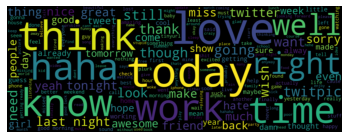

In [101]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

all_words = ' '.join(text for text in combine['Tidy_Tweets'])

#mage_colors = ImageColorGenerator(img) #can use image to color the wordcloud

wc = WordCloud(background_color='black', height=1500, width=4000).generate(all_words)
plt.axis('off')
plt.imshow(wc,interpolation="hamming")

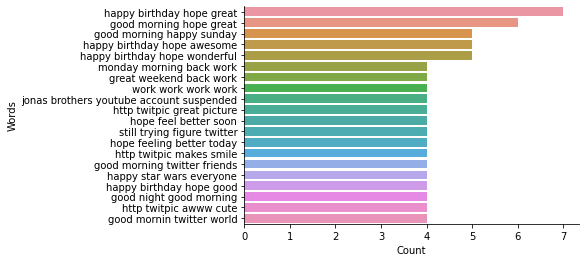

In [102]:
ht_words = nltk.FreqDist(combine['Tidy_Tweets'])
visual_df = pd.DataFrame({'Words':list(ht_words.keys()),'Count':list(ht_words.values())})

#display the most common words
word_plot = visual_df.nlargest(20, columns='Count')

sns.barplot(data=word_plot,y='Words',x='Count')
sns.despine()

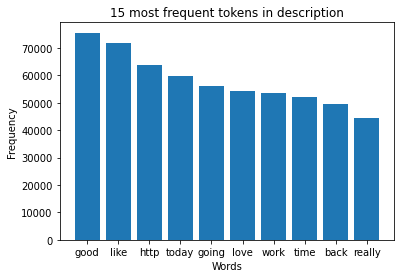

In [103]:
from collections import Counter

text_list = combine['Tidy_Tweets'].values.tolist()

word_freq = Counter(" ".join(text_list).split()).most_common(10)

words = [word for word, _ in word_freq]
counts = [counts for _, counts in word_freq]

plt.bar(words, counts)
plt.title("15 most frequent tokens in description")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()